In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#!ls drive/My\ Drive/cmpe256-data

country_reservoir = pd.read_csv('/content/drive/My Drive/cmpe256-data/ReservoirSensor-County.csv',low_memory=False)
country_reservoir.head()

,Station,County
0,KLM,SISKIYOU
1,GBR,SISKIYOU
2,IRG,SISKIYOU
3,CLK,MODOC
4,DWN,SISKIYOU


In [4]:
outflow = pd.read_csv('/content/drive/My Drive/cmpe256-data/outflow2.csv',low_memory=False)
outflow.head()

,Sensor,Date,Value
0,BER,200501,51.533333
1,BER,200502,53.166667
2,BER,200503,638.333333
3,BER,200504,684.700000
4,BER,200505,540.000000


In [0]:
outflow['DateTime'] = pd.to_datetime(outflow['Date'],format='%Y%m')
outflow['Year'] = pd.to_datetime(outflow['Date'],format='%Y%m').dt.year
outflow['Month'] = pd.to_datetime(outflow['Date'],format='%Y%m').dt.month

In [6]:
country_reservoir['Station'] = country_reservoir['Station'].apply(lambda x: x.strip())
merged_outflow = pd.merge(outflow,country_reservoir,how='inner', left_on='Sensor', right_on='Station')
merged_outflow.head()

,Sensor,Date,Value,DateTime,Year,Month,Station,County
0,BER,200501,51.533333,2005-01-01,2005,1,BER,NAPA
1,BER,200502,53.166667,2005-02-01,2005,2,BER,NAPA
2,BER,200503,638.333333,2005-03-01,2005,3,BER,NAPA
3,BER,200504,684.700000,2005-04-01,2005,4,BER,NAPA
4,BER,200505,540.000000,2005-05-01,2005,5,BER,NAPA


In [7]:
merged_outflow['PortableWaterInGallons'] = merged_outflow['Value'].apply(lambda x:  x* 748)
merged_outflow.head()

,Sensor,Date,Value,DateTime,Year,Month,Station,County,PortableWaterInGallons
0,BER,200501,51.533333,2005-01-01,2005,1,BER,NAPA,38546.933331
1,BER,200502,53.166667,2005-02-01,2005,2,BER,NAPA,39768.666669
2,BER,200503,638.333333,2005-03-01,2005,3,BER,NAPA,477473.333308
3,BER,200504,684.700000,2005-04-01,2005,4,BER,NAPA,512155.600000
4,BER,200505,540.000000,2005-05-01,2005,5,BER,NAPA,403920.000000


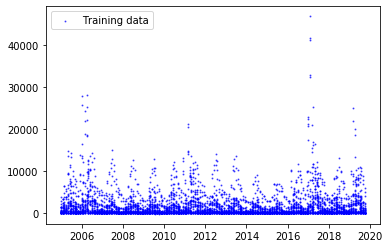

In [8]:
x = merged_outflow['DateTime']
y = merged_outflow['Value']

plt.scatter(x, y, c='b', s=1, alpha = 0.6, label='Training data')
plt.legend()
plt.show()


In [9]:
merged_outflow = merged_outflow.rename(columns={'DateTime': 'ds', 'Value': 'y'})
merged_outflow.tail()



,Sensor,Date,y,ds,Year,Month,Station,County,PortableWaterInGallons
5223,WRS,201906,149.866667,2019-06-01,2019,6,WRS,SONOMA,112100.266692
5224,WRS,201907,102.900000,2019-07-01,2019,7,WRS,SONOMA,76969.200000
5225,WRS,201908,103.133333,2019-08-01,2019,8,WRS,SONOMA,77143.733308
5226,WRS,201909,97.800000,2019-09-01,2019,9,WRS,SONOMA,73154.400000
5227,WRS,201910,97.800000,2019-10-01,2019,10,WRS,SONOMA,73154.400000


In [0]:
merged_outflow = merged_outflow[merged_outflow['Year'] >= 2010]

In [11]:
outflow_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
outflow_prophet.fit(merged_outflow)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


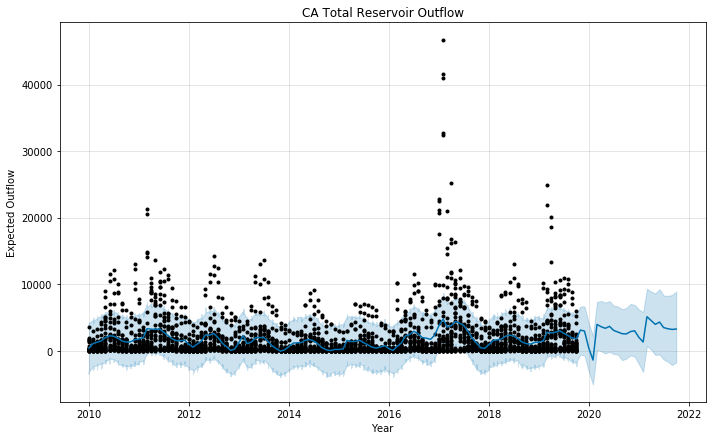

In [12]:
# Make a future dataframe for 2 years
outflow_forecast = outflow_prophet.make_future_dataframe(periods=12 * 2, freq='M')
# Make predictions
outflow_forecast = outflow_prophet.predict(outflow_forecast)

outflow_prophet.plot(outflow_forecast, xlabel = 'Year', ylabel = 'Expected Outflow')
plt.title('CA Total Reservoir Outflow');

In [13]:
outflow_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,269.713469,-3035.335295,4206.401365,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
1,2010-01-01,269.713469,-3190.711252,4035.259855,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
2,2010-01-01,269.713469,-3201.084393,4052.862082,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
3,2010-01-01,269.713469,-3282.223869,3777.141436,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
4,2010-01-01,269.713469,-3248.283443,4105.519017,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623


In [14]:
print(outflow_forecast.shape)


(3512, 16)


In [0]:
# Vertification Metrics -- testing the model
# https://facebook.github.io/prophet/docs/diagnostics.html
import pickle
filename = '/content/drive/My Drive/cmpe256-data/outlfow_phrophet.pkl'
pickle.dump(outflow_prophet, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

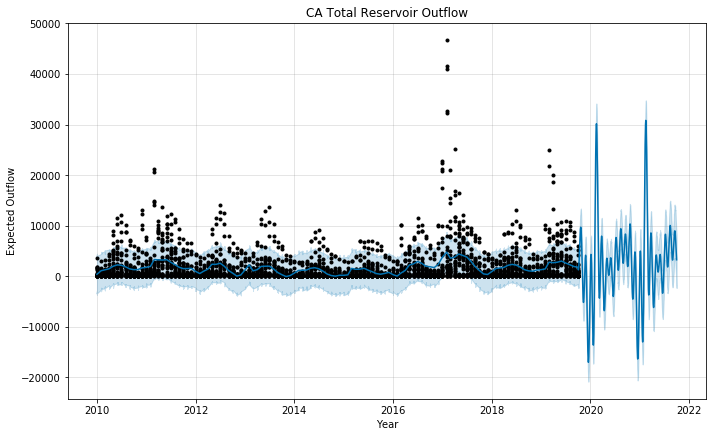

In [16]:
outflow_forecast = loaded_model.make_future_dataframe(periods=365*2, freq='D')
# Make predictions
outflow_forecast = loaded_model.predict(outflow_forecast)

loaded_model.plot(outflow_forecast, xlabel = 'Year', ylabel = 'Expected Outflow')
plt.title('CA Total Reservoir Outflow');

In [17]:
outflow_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,269.713469,-3124.997538,4162.057278,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
1,2010-01-01,269.713469,-3262.713027,3848.304364,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
2,2010-01-01,269.713469,-3373.145989,4064.761660,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
3,2010-01-01,269.713469,-3244.172324,4462.464824,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
4,2010-01-01,269.713469,-3337.575201,4106.572936,269.713469,269.713469,140.394154,140.394154,140.394154,140.394154,140.394154,140.394154,0.0,0.0,0.0,410.107623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,2021-09-26,3208.761731,-223.610144,10455.179328,-766.630718,6921.069655,2108.602420,2108.602420,2108.602420,2108.602420,2108.602420,2108.602420,0.0,0.0,0.0,5317.364151
4214,2021-09-27,3210.527778,-947.543275,9818.867531,-776.666757,6925.603077,1524.416870,1524.416870,1524.416870,1524.416870,1524.416870,1524.416870,0.0,0.0,0.0,4734.944648
4215,2021-09-28,3212.293825,-2017.296833,9303.886419,-786.702795,6927.299580,974.873048,974.873048,974.873048,974.873048,974.873048,974.873048,0.0,0.0,0.0,4187.166873
4216,2021-09-29,3214.059871,-1740.603463,8780.825335,-796.738833,6928.957802,479.571392,479.571392,479.571392,479.571392,479.571392,479.571392,0.0,0.0,0.0,3693.631264


In [18]:
outflow_forecast.drop_duplicates(subset=['yhat'], keep=False)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2108,2016-01-01,741.738313,-3432.848773,4093.826353,741.738313,741.738313,-409.912675,-409.912675,-409.912675,-409.912675,-409.912675,-409.912675,0.0,0.0,0.0,331.825638
3488,2019-10-02,1928.377798,-1957.816791,5119.855710,1928.377798,1928.377798,-407.453930,-407.453930,-407.453930,-407.453930,-407.453930,-407.453930,0.0,0.0,0.0,1520.923868
3489,2019-10-03,1930.143845,-2259.822488,4797.931072,1930.143845,1930.143845,-584.835154,-584.835154,-584.835154,-584.835154,-584.835154,-584.835154,0.0,0.0,0.0,1345.308692
3490,2019-10-04,1931.909892,-2099.218024,4834.560998,1931.909892,1931.909892,-645.993099,-645.993099,-645.993099,-645.993099,-645.993099,-645.993099,0.0,0.0,0.0,1285.916793
3491,2019-10-05,1933.675939,-2265.957863,4880.763659,1933.675939,1933.675939,-585.914257,-585.914257,-585.914257,-585.914257,-585.914257,-585.914257,0.0,0.0,0.0,1347.761681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,2021-09-26,3208.761731,-223.610144,10455.179328,-766.630718,6921.069655,2108.602420,2108.602420,2108.602420,2108.602420,2108.602420,2108.602420,0.0,0.0,0.0,5317.364151
4214,2021-09-27,3210.527778,-947.543275,9818.867531,-776.666757,6925.603077,1524.416870,1524.416870,1524.416870,1524.416870,1524.416870,1524.416870,0.0,0.0,0.0,4734.944648
4215,2021-09-28,3212.293825,-2017.296833,9303.886419,-786.702795,6927.299580,974.873048,974.873048,974.873048,974.873048,974.873048,974.873048,0.0,0.0,0.0,4187.166873
4216,2021-09-29,3214.059871,-1740.603463,8780.825335,-796.738833,6928.957802,479.571392,479.571392,479.571392,479.571392,479.571392,479.571392,0.0,0.0,0.0,3693.631264


In [41]:
len(outflow_forecast.ds.unique())

848

In [48]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(loaded_model,initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 14 forecasts with cutoffs between 2012-05-05 00:00:00 and 2018-10-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-01,3782.641203,606.334812,7110.864532,448.300000,2012-05-05
1,2012-06-01,3782.641203,453.556864,7051.836939,2234.833333,2012-05-05
2,2012-06-01,3782.641203,629.211262,7026.039132,183.000000,2012-05-05
3,2012-06-01,3782.641203,655.271872,7162.795940,1961.533333,2012-05-05
4,2012-06-01,3782.641203,352.505523,6953.987557,244.300000,2012-05-05


In [49]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,37 days,4.811529e+06,2193.519669,1545.493885,0.874162
1,40 days,4.407396e+06,2099.379946,1454.316006,0.878032
2,42 days,4.500963e+06,2121.547244,1502.506166,0.878032
3,45 days,4.361831e+06,2088.499742,1445.875311,0.878032
4,48 days,4.575736e+06,2139.097076,1513.865968,0.874162


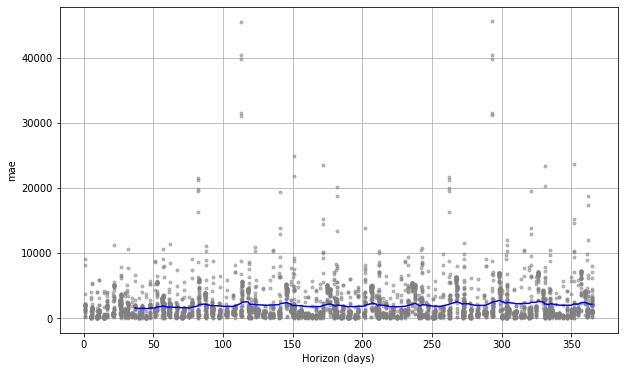

In [51]:
# Python
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')